In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import re
import string
import nltk

import tensorflow as tf

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jupyter/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [43]:
FILE_PATH = "../../data/spam.csv"

df = pd.read_csv(FILE_PATH, encoding="latin-1")

df = df.dropna(how="any", axis=1)

df = df.drop_duplicates(subset=['v2'])

df = df.rename(columns={ "v1": "target", "v2": "message" })

df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [44]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

def process_df(df):
    df['processed'] = df['message'].apply(clean_text)
    return df

df = process_df(df)
df.head()

,target,message,processed
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


In [45]:
def remove_stopwords_lemmatizer(text):
    lem = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    more_stopwords = ['u', 'im', 'c']
    stop_words = stop_words + more_stopwords
    text = ' '.join(lem.lemmatize(word) for word in text.split(' ') if word not in stop_words)
    return text

    
df['processed'] = df['processed'].apply(remove_stopwords_lemmatizer)
df.head()


,target,message,processed
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


In [46]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

df['processed'] = df['processed'].apply(stemm_text)
df.head()

,target,message,processed
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


In [47]:
df['target'] = df['target'].apply(lambda x: 1 if x == "spam" else 0)
df.head()

# To be replaced with spam 1, ham 0

,target,message,processed
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkts m...
3,0,U dun say so early hor... U c already then say...,dun say earli hor alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


In [48]:
texts = df['processed']
target = df['target']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    texts, 
    target, 
    test_size=0.25,
    random_state=42,
)

In [50]:
len(X_train)

3876

In [51]:
word_tokenizer = tf.keras.preprocessing.text.Tokenizer()
word_tokenizer.fit_on_texts(X_train)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

5698

In [52]:
max_length = 80

In [53]:
metadata = {}
metadata["vocabulary_size"] = vocab_length
metadata["max_length"] = max_length

In [54]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('./glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57832998, -0.0036551 ,  0.34658   , ...,  0.070204  ,
         0.44509   ,  0.24147999],
       [-0.078894  ,  0.46160001,  0.57779002, ...,  0.26352   ,
         0.59397   ,  0.26741001],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.22465   , -0.27485001, -0.40046999, ...,  0.23127   ,
        -0.34299001, -0.43200999],
       [-0.058209  , -0.12615   , -0.60170001, ..., -0.31284001,
        -0.24029   , -0.14884999]])

In [55]:
embedding_matrix.shape

(5698, 100)

In [57]:
len(X_train)

3876

In [58]:
len(X_train[0].split(" "))

16

In [59]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

train_padded_sentences = tf.keras.preprocessing.sequence.pad_sequences(
    embed(X_train), 
    max_length, 
    padding='post'
)

train_padded_sentences.shape

(3876, 80)

In [60]:
import json
word_index = {}
for word, index in word_tokenizer.word_index.items():
    word_index[word] = index

metadata["word_index"] = word_index

with open("metadata.json", "w") as f:
    json.dump(metadata, f)

In [61]:
def glove_lstm(max_length):
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Input((max_length,)))
    
    # model.add(tf.keras.layers.Embedding(
    #     input_dim=embedding_matrix.shape[0], 
    #     output_dim=embedding_matrix.shape[1], 
    #     weights = [embedding_matrix], 
    #     input_length=length_long_sentence
    # ))
    
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_length,
        output_dim=embedding_dim,
        input_length=max_length,
        weights = [embedding_matrix],
        trainable=False
    ))
    
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        max_length, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(tf.keras.layers.GlobalMaxPool1D())
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(max_length, activation = "relu"))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(max_length, activation = "relu"))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = glove_lstm(max_length)
model.summary()

2022-06-28 03:36:43.978635: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 100)           569800    
                                                                 
 bidirectional (Bidirectiona  (None, 80, 160)          115840    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 160)              0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                        

In [62]:
test_padded_sentences = tf.keras.preprocessing.sequence.pad_sequences(
    embed(X_test), 
    max_length, 
    padding='post'
)

In [63]:
history = model.fit(
    train_padded_sentences, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = (test_padded_sentences, y_test),
    verbose = 1,
)

Epoch 1/7
122/122 [==============================] - 72s 546ms/step - loss: 0.3252 - accuracy: 0.8749 - val_loss: 0.3402 - val_accuracy: 0.9443
Epoch 2/7
122/122 [==============================] - 66s 545ms/step - loss: 0.1944 - accuracy: 0.9309 - val_loss: 0.1707 - val_accuracy: 0.9551
Epoch 3/7
122/122 [==============================] - 65s 532ms/step - loss: 0.1595 - accuracy: 0.9510 - val_loss: 0.1189 - val_accuracy: 0.9544
Epoch 4/7
122/122 [==============================] - 65s 537ms/step - loss: 0.1352 - accuracy: 0.9582 - val_loss: 0.1353 - val_accuracy: 0.9474
Epoch 5/7
122/122 [==============================] - 67s 547ms/step - loss: 0.1232 - accuracy: 0.9662 - val_loss: 0.1009 - val_accuracy: 0.9637
Epoch 6/7
122/122 [==============================] - 66s 541ms/step - loss: 0.1041 - accuracy: 0.9698 - val_loss: 0.0948 - val_accuracy: 0.9714
Epoch 7/7
122/122 [==============================] - 65s 530ms/step - loss: 0.1049 - accuracy: 0.9727 - val_loss: 0.1478 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


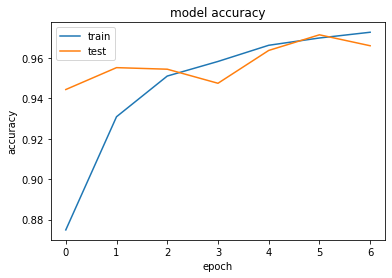

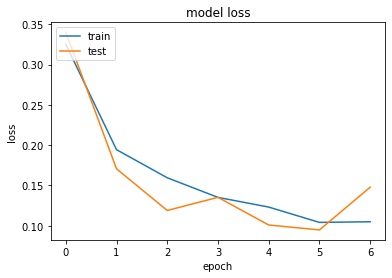

In [70]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [64]:
!mkdir -p saved_model
model.save('lstm_glove')

2022-06-28 03:45:15.151726: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: lstm_glove/assets


In [65]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format tfjs_graph_model --control_flow_v2=true ./lstm_glove ./tfjs_lstm_glove

/bin/bash: tensorflowjs_converter: command not found


In [66]:
test = np.zeros((1,80))
test[0][0] = 1000
test

array([[1000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])

In [67]:
model.predict(test)

array([[1.0036471e-05]], dtype=float32)